In [1]:
import os
import numpy as np
import tensorflow as tf
import shutil

In [2]:
TRAIN_DIR = "./data/train"

BRIGHT_PIXEL_THRESHOLD = 240   # pixel gần trắng
BRIGHT_RATIO_THRESHOLD = 0.25  # >25% pixel trắng => chói

In [ ]:
# Kiểm tra ảnh có bị chói không
def is_overexposed_tf(img_path):
    try:
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        gray = tf.image.rgb_to_grayscale(img)

        bright_ratio = tf.reduce_mean(
            tf.cast(gray > BRIGHT_PIXEL_THRESHOLD, tf.float32)
        ).numpy()

        return bright_ratio > BRIGHT_RATIO_THRESHOLD, bright_ratio

    except Exception:
        return False, 0.0


In [ ]:
#Scan bright images in training set
report = {}

for cls in os.listdir(TRAIN_DIR):
    cls_path = os.path.join(TRAIN_DIR, cls)
    if not os.path.isdir(cls_path):
        continue

    bad_count = 0
    total = 0

    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        total += 1
        is_bad, _ = is_overexposed_tf(img_path)
        if is_bad:
            bad_count += 1

    report[cls] = (bad_count, total)
    print(f"{cls}: {bad_count}/{total} ảnh chói")


Apple___Apple_scab: 0/2016 ảnh chói
Apple___Black_rot: 0/1987 ảnh chói
Apple___Cedar_apple_rust: 202/1760 ảnh chói
Apple___healthy: 1/2008 ảnh chói
Blueberry___healthy: 183/1816 ảnh chói
Cherry_(including_sour)___healthy: 0/1826 ảnh chói
Cherry_(including_sour)___Powdery_mildew: 0/1683 ảnh chói
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 0/1642 ảnh chói
Corn_(maize)___Common_rust_: 0/1907 ảnh chói
Corn_(maize)___healthy: 0/1859 ảnh chói
Corn_(maize)___Northern_Leaf_Blight: 0/1908 ảnh chói
Grape___Black_rot: 0/1888 ảnh chói
Grape___Esca_(Black_Measles): 0/1920 ảnh chói
Grape___healthy: 2/1692 ảnh chói
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 0/1722 ảnh chói
Orange___Haunglongbing_(Citrus_greening): 0/2010 ảnh chói
Peach___Bacterial_spot: 0/1838 ảnh chói
Peach___healthy: 281/1728 ảnh chói
Pepper,_bell___Bacterial_spot: 0/1913 ảnh chói
Pepper,_bell___healthy: 205/1988 ảnh chói
Potato___Early_blight: 0/1939 ảnh chói
Potato___healthy: 125/1824 ảnh chói
Potato___Late_blight: 0/193

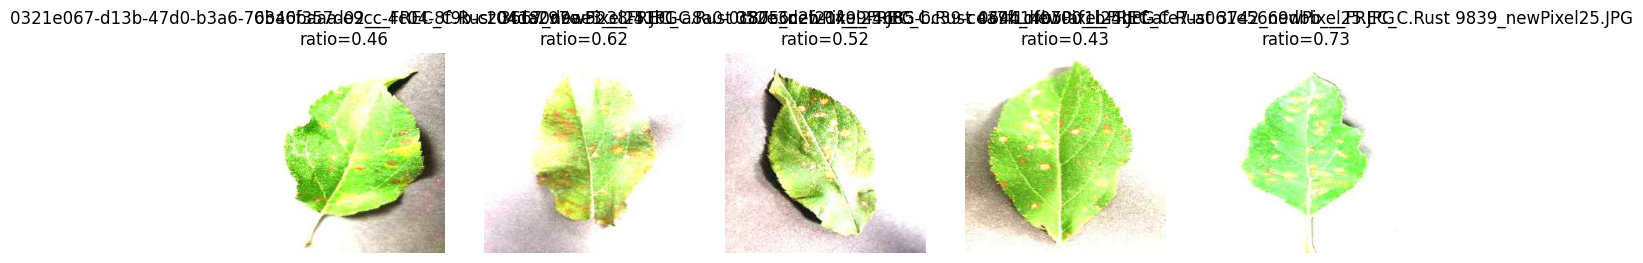

In [ ]:
#Show bad image
import matplotlib.pyplot as plt

def show_bright_images_train(cls, max_show=5):
    cls_path = os.path.join(TRAIN_DIR, cls)

    shown = 0
    plt.figure(figsize=(15, 5))

    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        is_bad, ratio = is_overexposed_tf(img_path)

        if is_bad:
            img = tf.image.decode_jpeg(tf.io.read_file(img_path))
            plt.subplot(1, max_show, shown + 1)
            plt.imshow(img)
            plt.title(f"{img_name}\nratio={ratio:.2f}")
            plt.axis("off")

            shown += 1
            if shown >= max_show:
                break

    plt.show()
show_bright_images_train("Apple___Cedar_apple_rust")


In [ ]:
# Move bad images to separate folder
MOVE_BAD = True

BAD_DIR = "./bad_images/train"
os.makedirs(BAD_DIR, exist_ok=True)

if MOVE_BAD:
    moved = 0
    for cls in os.listdir(TRAIN_DIR):
        cls_path = os.path.join(TRAIN_DIR, cls)
        if not os.path.isdir(cls_path):
            continue

        cls_bad_dir = os.path.join(BAD_DIR, cls)
        os.makedirs(cls_bad_dir, exist_ok=True)

        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            is_bad, _ = is_overexposed_tf(img_path)

            if is_bad:
                shutil.move(img_path, os.path.join(cls_bad_dir, img_name))
                moved += 1

    print(f"📦 Đã move {moved} ảnh chói khỏi train")


📦 Đã move 1941 ảnh chói khỏi train


In [8]:
import tensorflow as tf

train_dir = "./data/train"
valid_dir = "./data/valid"
test_dir  = "./data/test"

img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, 
    image_size=img_size, 
    batch_size=batch_size
)
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir, 
    image_size=img_size, 
    batch_size=batch_size
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, 
    image_size=img_size, 
    batch_size=batch_size
)

Found 68354 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.
Found 33 files belonging to 1 classes.


In [9]:
class_names = train_ds.class_names
num_classes = len(class_names)

print("Number of classes:", num_classes)
print("Classes:", class_names)

Number of classes: 38
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_sp

In [ ]:
# Data augmentation
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.15),
    layers.RandomContrast(0.15),
    layers.Lambda(preprocess_input)   # chuẩn hóa [-1, 1]
])

In [ ]:
# Build the model
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

inputs = tf.keras.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step



In [63]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │        36,518 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,105,908 (11.85 MB)

 Trainable params: 36,518 (142.65 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

 Optimizer params: 73,038 (285.31 KB)

In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# Reduce learning rate when a metric has stopped improving
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", # theo dõi lỗi validation
    factor=0.3, # LR mới = LR cũ × 0.3
    patience=3, # đợi 3 epoch không cải thiện
    min_lr=1e-6 # LR nhỏ nhất cho phép
)

In [ ]:
# Save the best model and implement early stopping

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint(
    "best_model.keras", 
    save_best_only=True, 
    monitor="val_loss", 
    mode="max"
)

early_stop = EarlyStopping(
    monitor="val_loss", 
    patience=5, 
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10,
    callbacks=[checkpoint, early_stop, reduce_lr]
)
print("Training complete.")

Epoch 1/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1034s 482ms/step - accuracy: 0.5472 - loss: 1.7587 - val_accuracy: 0.8383 - val_loss: 0.7316 - learning_rate: 1.0000e-04
Epoch 2/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1015s 475ms/step - accuracy: 0.8409 - loss: 0.6454 - val_accuracy: 0.8931 - val_loss: 0.4410 - learning_rate: 1.0000e-04
Epoch 3/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1017s 476ms/step - accuracy: 0.8902 - loss: 0.4359 - val_accuracy: 0.9126 - val_loss: 0.3390 - learning_rate: 1.0000e-04
Epoch 4/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1032s 483ms/step - accuracy: 0.9099 - loss: 0.3437 - val_accuracy: 0.9219 - val_loss: 0.2920 - learning_rate: 1.0000e-04
Epoch 5/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1106s 517ms/step - accuracy: 0.9217 - loss: 0.2922 - val_accuracy: 0.9313 - val_loss: 0.2585 - learning_rate: 1.0000e-04
Epoch 6/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1066s 499ms/step - accuracy: 0.9295 - loss: 0.2613 - val_accuracy: 0.9358 - val_loss: 0.2400 - learning_rate: 1.0000e-04
Epoch 7/10
2137/2137 ━

In [15]:
print("Best val_acc:", max(history.history["val_accuracy"]))
print("Best val_loss:", min(history.history["val_loss"]))

Best val_acc: 0.9461643695831299
Best val_loss: 0.19515138864517212


In [ ]:
import os
import numpy as np
import tensorflow as tf

# ===============================
# LOAD TEST (NO LABEL)
# ===============================
test_dir_real = test_dir + "/test" 
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_real,
    image_size=img_size,
    batch_size=batch_size,
    label_mode=None,
    shuffle=False
)

# ===============================
# FILE TEST
# ===============================
test_files = sorted([
    f for f in os.listdir(test_dir_real)
    if f.lower().endswith((".jpg", ".png", ".jpeg"))
])

print("Số ảnh test:", len(test_files))

# ===============================
# CLASS TRAIN
# ===============================
class_names = train_ds.class_names

# ===============================
# HÀM TÌM CLASS TRAIN THEO KEYWORD
# ===============================
def find_class_by_keywords(keywords):
    for cls in class_names:
        cls_lower = cls.lower()
        if all(k in cls_lower for k in keywords):
            return cls
    return None

# ===============================
# MAP FILE → CLASS
# ===============================
true_labels = []
valid_indices = []

for i, fname in enumerate(test_files):
    name = fname.lower()

    cls_name = None

    if "apple" in name and "cedar" in name:
        cls_name = find_class_by_keywords(["apple", "cedar"])
    elif "apple" in name and "scab" in name:
        cls_name = find_class_by_keywords(["apple", "scab"])

    elif "corn" in name and "rust" in name:
        cls_name = find_class_by_keywords(["corn", "rust"])

    elif "potato" in name and "earlyblight" in name:
        cls_name = find_class_by_keywords(["potato", "early", "blight"])
    elif "potato" in name and "healthy" in name:
        cls_name = find_class_by_keywords(["potato", "healthy"])

    elif "tomato" in name and "earlyblight" in name:
        cls_name = find_class_by_keywords(["tomato", "early", "blight"])
    elif "tomato" in name and "yellowcurlvirus" in name:
        cls_name = find_class_by_keywords(["tomato", "yellow", "curl"])
    elif "tomato" in name and "healthy" in name:
        cls_name = find_class_by_keywords(["tomato", "healthy"])

    if cls_name is None:
        print("⚠️ Không map được:", fname)
        continue

    true_labels.append(class_names.index(cls_name))
    valid_indices.append(i)

true_labels = np.array(true_labels)
print("Số ảnh test hợp lệ:", len(true_labels))

# ===============================
# PREDICT
# ===============================
preds = model.predict(test_ds)
pred_labels = np.argmax(preds, axis=1)
pred_labels = pred_labels[valid_indices]

# ===============================
# ACCURACY
# ===============================
accuracy = np.mean(pred_labels == true_labels)
print(f"✅ Test accuracy (from filename): {accuracy:.4f}")


Found 33 files.
Số ảnh test: 33
Số ảnh test hợp lệ: 33
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step 
✅ Test accuracy (from filename): 0.7576


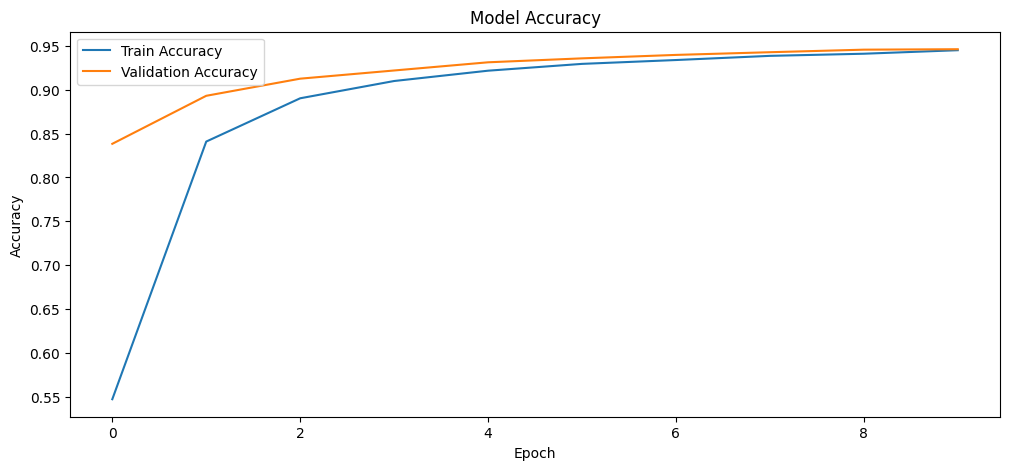

In [57]:
import matplotlib.pyplot as plt

#Biểu đồ Accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy') 
plt.legend()
plt.show()

In [19]:
from tensorflow.keras.utils import load_img, img_to_array

def predict_image(model, img_path, class_names):
    img = load_img(img_path, target_size=img_size)
    img = img_to_array(img)
    img = tf.expand_dims(img, axis=0)

    preds = model.predict(img)
    idx = np.argmax(preds)
    conf = np.max(preds)

    return class_names[idx], conf

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
🌿 Dự đoán: Potato___healthy (98.36%)


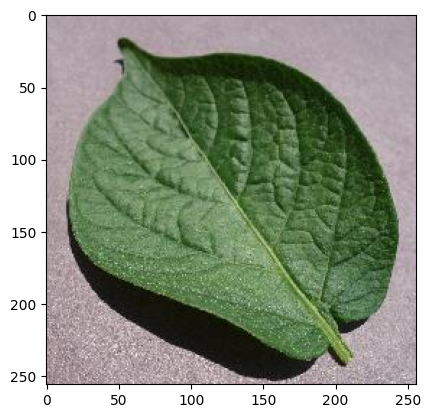

In [23]:
# Đường dẫn ảnh cần test
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

img_path = "C:\\HuaKhanhDuy\\MC\\New Plant Diseases Dataset(Augmented)\\data\\test\\test\\PotatoHealthy1.JPG"   # đổi thành ảnh của bạn
label, conf = predict_image(model, img_path, class_names)
plt.imshow(image.load_img(img_path))
print(f"🌿 Dự đoán: {label} ({conf:.2%})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
🌿 Dự đoán: Apple___Cedar_apple_rust (99.66%)


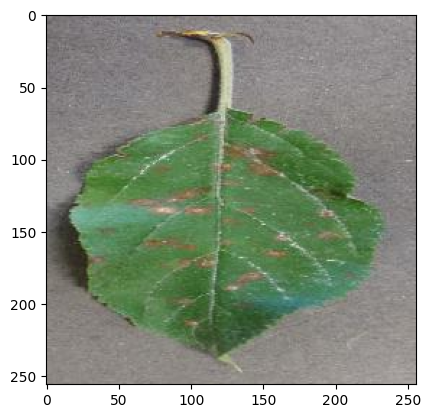

In [ ]:
# Đường dẫn ảnh cần test
img_path = "C:\\HuaKhanhDuy\\MC\\New Plant Diseases Dataset(Augmented)\\data\\test\\test\\AppleCedarRust2.JPG"
label, conf = predict_image(model, img_path, class_names)
plt.imshow(image.load_img(img_path))
print(f"🌿 Dự đoán: {label} ({conf:.2%})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
🌿 Dự đoán: Tomato___Septoria_leaf_spot (58.77%)


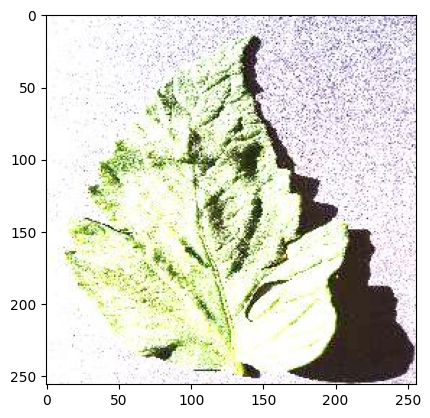

In [58]:
# Đường dẫn ảnh cần test
img_path = "C:\\HuaKhanhDuy\\MC\\New Plant Diseases Dataset(Augmented)\\data\\test\\test\\TomatoHealthy4.JPG"
label, conf = predict_image(model, img_path, class_names)
plt.imshow(image.load_img(img_path))
print(f"🌿 Dự đoán: {label} ({conf:.2%})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
🌿 Dự đoán: Tomato___Tomato_Yellow_Leaf_Curl_Virus (98.71%)


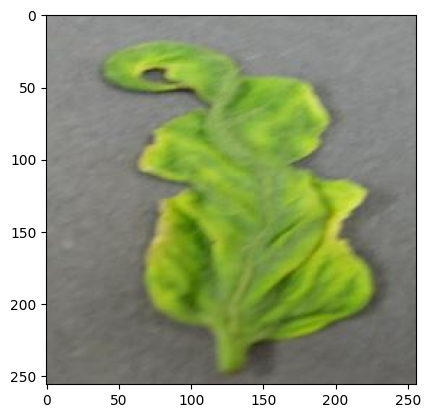

In [59]:
# Đường dẫn ảnh cần test
img_path = "C:\\HuaKhanhDuy\\MC\\New Plant Diseases Dataset(Augmented)\\data\\test\\test\\TomatoYellowCurlVirus5.JPG"
label, conf = predict_image(model, img_path, class_names)
plt.imshow(image.load_img(img_path))
print(f"🌿 Dự đoán: {label} ({conf:.2%})")

In [29]:
import json

model.save("leaf_disease_model.keras")

with open("class_names.json", "w", encoding="utf-8") as f:
    json.dump(class_names, f, ensure_ascii=False)

print("✅ Đã lưu model và class_names")


✅ Đã lưu model và class_names
